In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [9]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el = 32
sciospec = EIT_16_32_64_128(n_el)

In [10]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [11]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [12]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [13]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [14]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [15]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 32, 32)

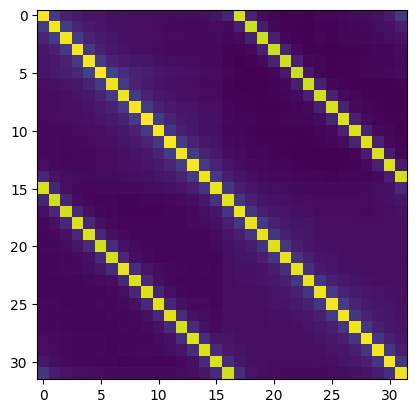

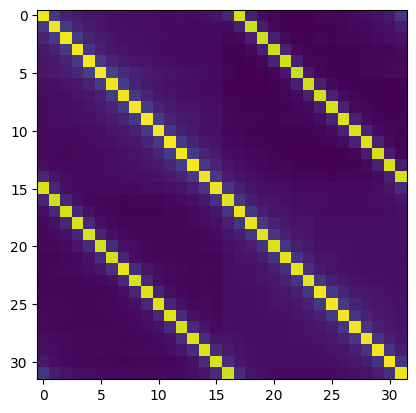

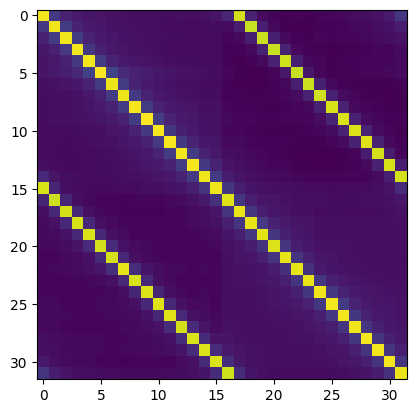

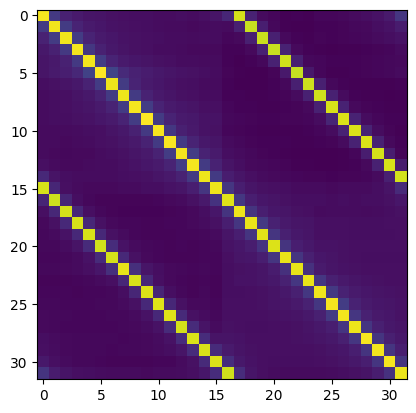

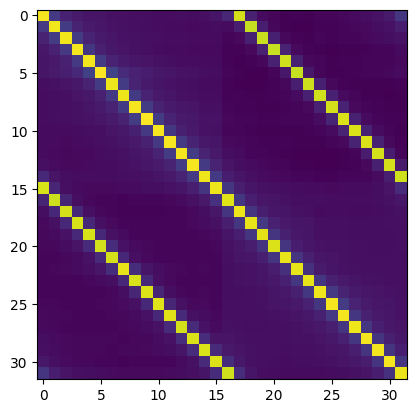

In [16]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [17]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    createTrajectory,
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [18]:
printer = EnderControl(com_port="/dev/ttyUSB0")
printer.connect()

Connection to /dev/ttyUSB0 is established.


## Initializing Printer ##

In [19]:
printer.init()

b'start\n'
b'echo: External Reset\n'
b'Marlin Ver 1.70.3 BL\n'
b'\n'
b'echo: Last Updated: 2022-02-24 | Author: Ender-5 Plus\n'
b'echo:Compiled: Feb 24 2022\n'
b'echo: Free Memory: 1406  PlannerBufferBytes: 1232\n'
b'echo:V42 stored settings retrieved (530 bytes; crc 12996)\n'
b'echo:  G21    ; Units in mm\n'
b'echo:  M149 C ; Units in Celsius\n'
b'\n'
b'echo:Filament settings: Disabled\n'
b'echo:  M200 D1.75\n'
b'echo:  M200 D0\n'
b'echo:Steps per unit:\n'
b'echo:  M92 X80.00 Y80.00 Z800.00 E92.60\n'
b'echo:Maximum feedrates (units/s):\n'
b'echo:  M203 X300.00 Y300.00 Z5.00 E25.00\n'
b'echo:Maximum Acceleration (units/s2):\n'
b'echo:  M201 X500 Y500 Z100 E1000\n'
b'echo:Acceleration (units/s2): P<print_accel> R<retract_accel> T<travel_accel>\n'
b'echo:  M204 P500.00 R500.00 T1000.00\n'
b'echo:Advanced: S<min_feedrate> T<min_travel_feedrate> B<min_segment_time_ms> X<max_xy_jerk> Z<max_z_jerk> E<max_e_jerk>\n'
b'echo:  M205 S0.00 T0.00 B20000 X10.00 Y10.00 Z0.40 E5.00\n'
b'echo:Home off

[180, 180]

## Generating and saving data ##

In [20]:
traj_type = "Kreis"  
r_path = 0.25
Nsteps = 1000 
material = "Acryl Glas"
r_anomaly = 10

def generate_exp_data(traj, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data):
    # Berechne die Trajektorie
    center_pos = createTrajectory("Kreis", r_path*97, r_path_variations=None, bound=0, num_points=Nsteps)
    
    # Erstelle den Basisordner für die Datenspeicherung
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": Nsteps,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        # Speichere die Messung (Start bei sample_000001.npz)
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")

def empty_tank_measure():
    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [21]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [22]:
generate_exp_data(traj_type, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, 
                  empty_tank_machine_time, empty_tank_temp, empty_tank_data)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

b'ok\n'


  0%|                                        | 1/1000 [00:04<1:15:25,  4.53s/it]

b'ok\n'


  0%|                                        | 2/1000 [00:09<1:15:29,  4.54s/it]

b'ok\n'


  0%|                                        | 3/1000 [00:13<1:15:19,  4.53s/it]

b'ok\n'


  0%|▏                                       | 4/1000 [00:18<1:15:11,  4.53s/it]

b'ok\n'


  0%|▏                                       | 5/1000 [00:22<1:15:07,  4.53s/it]

b'ok\n'


  1%|▏                                       | 6/1000 [00:27<1:15:08,  4.54s/it]

b'ok\n'


  1%|▎                                       | 7/1000 [00:31<1:15:07,  4.54s/it]

b'ok\n'


  1%|▎                                       | 8/1000 [00:36<1:15:06,  4.54s/it]

b'ok\n'


  1%|▎                                       | 9/1000 [00:40<1:15:02,  4.54s/it]

b'ok\n'


  1%|▍                                      | 10/1000 [00:45<1:14:58,  4.54s/it]

b'ok\n'


  1%|▍                                      | 11/1000 [00:49<1:14:49,  4.54s/it]

b'ok\n'


  1%|▍                                      | 12/1000 [00:54<1:14:47,  4.54s/it]

b'ok\n'


  1%|▌                                      | 13/1000 [00:59<1:14:43,  4.54s/it]

b'ok\n'


  1%|▌                                      | 14/1000 [01:03<1:14:38,  4.54s/it]

b'ok\n'


  2%|▌                                      | 15/1000 [01:08<1:14:29,  4.54s/it]

b'ok\n'


  2%|▌                                      | 16/1000 [01:12<1:14:18,  4.53s/it]

b'ok\n'


  2%|▋                                      | 17/1000 [01:17<1:14:12,  4.53s/it]

b'ok\n'


  2%|▋                                      | 18/1000 [01:21<1:14:11,  4.53s/it]

b'ok\n'


  2%|▋                                      | 19/1000 [01:26<1:14:09,  4.54s/it]

b'ok\n'


  2%|▊                                      | 20/1000 [01:30<1:14:07,  4.54s/it]

b'ok\n'


  2%|▊                                      | 21/1000 [01:35<1:14:05,  4.54s/it]

b'ok\n'


  2%|▊                                      | 22/1000 [01:39<1:14:02,  4.54s/it]

b'ok\n'


  2%|▉                                      | 23/1000 [01:44<1:13:59,  4.54s/it]

b'ok\n'


  2%|▉                                      | 24/1000 [01:48<1:13:45,  4.53s/it]

b'ok\n'


  2%|▉                                      | 25/1000 [01:53<1:13:43,  4.54s/it]

b'ok\n'


  3%|█                                      | 26/1000 [01:57<1:13:42,  4.54s/it]

b'ok\n'


  3%|█                                      | 27/1000 [02:02<1:13:41,  4.54s/it]

b'ok\n'


  3%|█                                      | 28/1000 [02:07<1:13:27,  4.53s/it]

b'ok\n'


  3%|█▏                                     | 29/1000 [02:11<1:13:25,  4.54s/it]

b'ok\n'


  3%|█▏                                     | 30/1000 [02:16<1:13:21,  4.54s/it]

b'ok\n'


  3%|█▏                                     | 31/1000 [02:20<1:13:19,  4.54s/it]

b'ok\n'


  3%|█▏                                     | 32/1000 [02:25<1:13:16,  4.54s/it]

b'ok\n'


  3%|█▎                                     | 33/1000 [02:29<1:13:11,  4.54s/it]

b'ok\n'


  3%|█▎                                     | 34/1000 [02:34<1:13:06,  4.54s/it]

b'ok\n'


  4%|█▎                                     | 35/1000 [02:38<1:13:02,  4.54s/it]

b'ok\n'


  4%|█▍                                     | 36/1000 [02:43<1:12:53,  4.54s/it]

b'ok\n'


  4%|█▍                                     | 37/1000 [02:47<1:12:50,  4.54s/it]

b'ok\n'


  4%|█▍                                     | 38/1000 [02:52<1:12:47,  4.54s/it]

b'ok\n'


  4%|█▌                                     | 39/1000 [02:57<1:12:44,  4.54s/it]

b'ok\n'


  4%|█▌                                     | 40/1000 [03:01<1:12:37,  4.54s/it]

b'ok\n'


  4%|█▌                                     | 41/1000 [03:06<1:12:33,  4.54s/it]

b'ok\n'


  4%|█▋                                     | 42/1000 [03:10<1:12:30,  4.54s/it]

b'ok\n'


  4%|█▋                                     | 43/1000 [03:15<1:12:27,  4.54s/it]

b'ok\n'


  4%|█▋                                     | 44/1000 [03:19<1:12:19,  4.54s/it]

b'ok\n'


  4%|█▊                                     | 45/1000 [03:24<1:12:10,  4.53s/it]

b'ok\n'


  5%|█▊                                     | 46/1000 [03:28<1:12:04,  4.53s/it]

b'ok\n'


  5%|█▊                                     | 47/1000 [03:33<1:12:03,  4.54s/it]

b'ok\n'


  5%|█▊                                     | 48/1000 [03:37<1:11:58,  4.54s/it]

b'ok\n'


  5%|█▉                                     | 49/1000 [03:42<1:11:55,  4.54s/it]

b'ok\n'


  5%|█▉                                     | 50/1000 [03:46<1:11:45,  4.53s/it]

b'ok\n'


  5%|█▉                                     | 51/1000 [03:51<1:11:46,  4.54s/it]

b'ok\n'


  5%|██                                     | 52/1000 [03:55<1:11:39,  4.54s/it]

b'ok\n'


  5%|██                                     | 53/1000 [04:00<1:11:28,  4.53s/it]

b'ok\n'


  5%|██                                     | 54/1000 [04:05<1:11:26,  4.53s/it]

b'ok\n'


  6%|██▏                                    | 55/1000 [04:09<1:11:26,  4.54s/it]

b'ok\n'


  6%|██▏                                    | 56/1000 [04:14<1:11:24,  4.54s/it]

b'ok\n'


  6%|██▏                                    | 57/1000 [04:18<1:11:20,  4.54s/it]

b'ok\n'


  6%|██▎                                    | 58/1000 [04:23<1:11:15,  4.54s/it]

b'ok\n'


  6%|██▎                                    | 59/1000 [04:27<1:11:13,  4.54s/it]

b'ok\n'


  6%|██▎                                    | 60/1000 [04:32<1:11:09,  4.54s/it]

b'ok\n'


  6%|██▍                                    | 61/1000 [04:36<1:11:04,  4.54s/it]

b'ok\n'


  6%|██▍                                    | 62/1000 [04:41<1:11:00,  4.54s/it]

b'ok\n'


  6%|██▍                                    | 63/1000 [04:45<1:10:57,  4.54s/it]

b'ok\n'


  6%|██▍                                    | 64/1000 [04:50<1:10:54,  4.55s/it]

b'ok\n'


  6%|██▌                                    | 65/1000 [04:55<1:10:49,  4.54s/it]

b'ok\n'


  7%|██▌                                    | 66/1000 [04:59<1:10:41,  4.54s/it]

b'ok\n'


  7%|██▌                                    | 67/1000 [05:04<1:10:38,  4.54s/it]

b'ok\n'


  7%|██▋                                    | 68/1000 [05:08<1:10:30,  4.54s/it]

b'ok\n'


  7%|██▋                                    | 69/1000 [05:13<1:10:26,  4.54s/it]

b'ok\n'


  7%|██▋                                    | 70/1000 [05:17<1:10:22,  4.54s/it]

b'ok\n'


  7%|██▊                                    | 71/1000 [05:22<1:10:19,  4.54s/it]

b'ok\n'


  7%|██▊                                    | 72/1000 [05:26<1:10:15,  4.54s/it]

b'ok\n'


  7%|██▊                                    | 73/1000 [05:31<1:10:04,  4.54s/it]

b'ok\n'


  7%|██▉                                    | 74/1000 [05:35<1:09:56,  4.53s/it]

b'ok\n'


  8%|██▉                                    | 75/1000 [05:40<1:09:47,  4.53s/it]

b'ok\n'


  8%|██▉                                    | 76/1000 [05:44<1:09:47,  4.53s/it]

b'ok\n'


  8%|███                                    | 77/1000 [05:49<1:09:45,  4.54s/it]

b'ok\n'


  8%|███                                    | 78/1000 [05:53<1:09:40,  4.53s/it]

b'ok\n'


  8%|███                                    | 79/1000 [05:58<1:09:38,  4.54s/it]

b'ok\n'


  8%|███                                    | 80/1000 [06:03<1:09:37,  4.54s/it]

b'ok\n'


  8%|███▏                                   | 81/1000 [06:07<1:09:34,  4.54s/it]

b'ok\n'


  8%|███▏                                   | 82/1000 [06:12<1:09:31,  4.54s/it]

b'ok\n'


  8%|███▏                                   | 83/1000 [06:16<1:09:26,  4.54s/it]

b'ok\n'


  8%|███▎                                   | 84/1000 [06:21<1:09:21,  4.54s/it]

b'ok\n'


  8%|███▎                                   | 85/1000 [06:25<1:09:15,  4.54s/it]

b'ok\n'


  9%|███▎                                   | 86/1000 [06:30<1:09:12,  4.54s/it]

b'ok\n'


  9%|███▍                                   | 87/1000 [06:34<1:09:08,  4.54s/it]

b'ok\n'


  9%|███▍                                   | 88/1000 [06:39<1:09:02,  4.54s/it]

b'ok\n'


  9%|███▍                                   | 89/1000 [06:43<1:08:58,  4.54s/it]

b'ok\n'


  9%|███▌                                   | 90/1000 [06:48<1:08:54,  4.54s/it]

b'ok\n'


  9%|███▌                                   | 91/1000 [06:53<1:08:44,  4.54s/it]

b'ok\n'


  9%|███▌                                   | 92/1000 [06:57<1:08:40,  4.54s/it]

b'ok\n'


  9%|███▋                                   | 93/1000 [07:02<1:08:37,  4.54s/it]

b'ok\n'


  9%|███▋                                   | 94/1000 [07:06<1:08:34,  4.54s/it]

b'ok\n'


 10%|███▋                                   | 95/1000 [07:11<1:08:30,  4.54s/it]

b'ok\n'


 10%|███▋                                   | 96/1000 [07:15<1:08:26,  4.54s/it]

b'ok\n'


 10%|███▊                                   | 97/1000 [07:20<1:08:21,  4.54s/it]

b'ok\n'


 10%|███▊                                   | 98/1000 [07:24<1:08:18,  4.54s/it]

b'ok\n'


 10%|███▊                                   | 99/1000 [07:29<1:08:02,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 100/1000 [07:33<1:08:00,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 101/1000 [07:38<1:07:54,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 102/1000 [07:42<1:07:54,  4.54s/it]

b'ok\n'


 10%|███▉                                  | 103/1000 [07:47<1:07:49,  4.54s/it]

b'ok\n'


 10%|███▉                                  | 104/1000 [07:52<1:07:46,  4.54s/it]

b'ok\n'


 10%|███▉                                  | 105/1000 [07:56<1:07:39,  4.54s/it]

b'ok\n'


 11%|████                                  | 106/1000 [08:01<1:07:37,  4.54s/it]

b'ok\n'


 11%|████                                  | 107/1000 [08:05<1:07:28,  4.53s/it]

b'ok\n'


 11%|████                                  | 108/1000 [08:10<1:07:26,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 109/1000 [08:14<1:07:17,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 110/1000 [08:19<1:07:16,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 111/1000 [08:23<1:07:14,  4.54s/it]

b'ok\n'


 11%|████▎                                 | 112/1000 [08:28<1:07:11,  4.54s/it]

b'ok\n'


 11%|████▎                                 | 113/1000 [08:32<1:07:07,  4.54s/it]

b'ok\n'


 11%|████▎                                 | 114/1000 [08:37<1:07:04,  4.54s/it]

b'ok\n'


 12%|████▎                                 | 115/1000 [08:41<1:06:54,  4.54s/it]

b'ok\n'


 12%|████▍                                 | 116/1000 [08:46<1:06:51,  4.54s/it]

b'ok\n'


 12%|████▍                                 | 117/1000 [08:51<1:06:49,  4.54s/it]

b'ok\n'


 12%|████▍                                 | 118/1000 [08:55<1:06:41,  4.54s/it]

b'ok\n'


 12%|████▌                                 | 119/1000 [09:00<1:06:36,  4.54s/it]

b'ok\n'


 12%|████▌                                 | 120/1000 [09:04<1:06:33,  4.54s/it]

b'ok\n'


 12%|████▌                                 | 121/1000 [09:09<1:06:28,  4.54s/it]

b'ok\n'


 12%|████▋                                 | 122/1000 [09:13<1:06:25,  4.54s/it]

b'ok\n'


 12%|████▋                                 | 123/1000 [09:18<1:06:21,  4.54s/it]

b'ok\n'


 12%|████▋                                 | 124/1000 [09:22<1:06:16,  4.54s/it]

b'ok\n'


 12%|████▊                                 | 125/1000 [09:27<1:06:13,  4.54s/it]

b'ok\n'


 13%|████▊                                 | 126/1000 [09:31<1:06:01,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 127/1000 [09:36<1:05:59,  4.54s/it]

b'ok\n'


 13%|████▊                                 | 128/1000 [09:40<1:05:47,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 129/1000 [09:45<1:05:47,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 130/1000 [09:49<1:05:46,  4.54s/it]

b'ok\n'


 13%|████▉                                 | 131/1000 [09:54<1:05:43,  4.54s/it]

b'ok\n'


 13%|█████                                 | 132/1000 [09:59<1:05:39,  4.54s/it]

b'ok\n'


 13%|█████                                 | 133/1000 [10:03<1:05:36,  4.54s/it]

b'ok\n'


 13%|█████                                 | 134/1000 [10:08<1:05:32,  4.54s/it]

b'ok\n'


 14%|█████▏                                | 135/1000 [10:12<1:05:28,  4.54s/it]

b'ok\n'


 14%|█████▏                                | 136/1000 [10:17<1:05:24,  4.54s/it]

b'ok\n'


 14%|█████▏                                | 137/1000 [10:21<1:05:20,  4.54s/it]

b'ok\n'


 14%|█████▏                                | 138/1000 [10:26<1:05:16,  4.54s/it]

b'ok\n'


 14%|█████▎                                | 139/1000 [10:30<1:05:12,  4.54s/it]

b'ok\n'


 14%|█████▎                                | 140/1000 [10:35<1:05:07,  4.54s/it]

b'ok\n'


 14%|█████▎                                | 141/1000 [10:39<1:05:02,  4.54s/it]

b'ok\n'


 14%|█████▍                                | 142/1000 [10:44<1:04:58,  4.54s/it]

b'ok\n'


 14%|█████▍                                | 143/1000 [10:49<1:04:52,  4.54s/it]

b'ok\n'


 14%|█████▍                                | 144/1000 [10:53<1:04:46,  4.54s/it]

b'ok\n'


 14%|█████▌                                | 145/1000 [10:58<1:04:35,  4.53s/it]

b'ok\n'


 15%|█████▌                                | 146/1000 [11:02<1:04:33,  4.54s/it]

b'ok\n'


 15%|█████▌                                | 147/1000 [11:07<1:04:31,  4.54s/it]

b'ok\n'


 15%|█████▌                                | 148/1000 [11:11<1:04:27,  4.54s/it]

b'ok\n'


 15%|█████▋                                | 149/1000 [11:16<1:04:25,  4.54s/it]

b'ok\n'


 15%|█████▋                                | 150/1000 [11:20<1:04:21,  4.54s/it]

b'ok\n'


 15%|█████▋                                | 151/1000 [11:25<1:04:07,  4.53s/it]

b'ok\n'


 15%|█████▊                                | 152/1000 [11:29<1:03:58,  4.53s/it]

b'ok\n'


 15%|█████▊                                | 153/1000 [11:34<1:03:58,  4.53s/it]

b'ok\n'


 15%|█████▊                                | 154/1000 [11:38<1:03:56,  4.53s/it]

b'ok\n'


 16%|█████▉                                | 155/1000 [11:43<1:03:53,  4.54s/it]

b'ok\n'


 16%|█████▉                                | 156/1000 [11:47<1:03:49,  4.54s/it]

b'ok\n'


 16%|█████▉                                | 157/1000 [11:52<1:03:46,  4.54s/it]

b'ok\n'


 16%|██████                                | 158/1000 [11:57<1:03:43,  4.54s/it]

b'ok\n'


 16%|██████                                | 159/1000 [12:01<1:03:36,  4.54s/it]

b'ok\n'


 16%|██████                                | 160/1000 [12:06<1:03:31,  4.54s/it]

b'ok\n'


 16%|██████                                | 161/1000 [12:10<1:03:28,  4.54s/it]

b'ok\n'


 16%|██████▏                               | 162/1000 [12:15<1:03:24,  4.54s/it]

b'ok\n'


 16%|██████▏                               | 163/1000 [12:19<1:03:19,  4.54s/it]

b'ok\n'


 16%|██████▏                               | 164/1000 [12:24<1:03:15,  4.54s/it]

b'ok\n'


 16%|██████▎                               | 165/1000 [12:28<1:03:08,  4.54s/it]

b'ok\n'


 17%|██████▎                               | 166/1000 [12:33<1:03:05,  4.54s/it]

b'ok\n'


 17%|██████▎                               | 167/1000 [12:37<1:03:01,  4.54s/it]

b'ok\n'


 17%|██████▍                               | 168/1000 [12:42<1:02:57,  4.54s/it]

b'ok\n'


 17%|██████▍                               | 169/1000 [12:47<1:02:53,  4.54s/it]

b'ok\n'


 17%|██████▍                               | 170/1000 [12:51<1:02:48,  4.54s/it]

b'ok\n'


 17%|██████▍                               | 171/1000 [12:56<1:02:44,  4.54s/it]

b'ok\n'


 17%|██████▌                               | 172/1000 [13:00<1:02:39,  4.54s/it]

b'ok\n'


 17%|██████▌                               | 173/1000 [13:05<1:02:35,  4.54s/it]

b'ok\n'


 17%|██████▌                               | 174/1000 [13:09<1:02:31,  4.54s/it]

b'ok\n'


 18%|██████▋                               | 175/1000 [13:14<1:02:27,  4.54s/it]

b'ok\n'


 18%|██████▋                               | 176/1000 [13:18<1:02:22,  4.54s/it]

b'ok\n'


 18%|██████▋                               | 177/1000 [13:23<1:02:15,  4.54s/it]

b'ok\n'


 18%|██████▊                               | 178/1000 [13:27<1:02:12,  4.54s/it]

b'ok\n'


 18%|██████▊                               | 179/1000 [13:32<1:02:05,  4.54s/it]

b'ok\n'


 18%|██████▊                               | 180/1000 [13:36<1:02:02,  4.54s/it]

b'ok\n'


 18%|██████▉                               | 181/1000 [13:41<1:01:56,  4.54s/it]

b'ok\n'


 18%|██████▉                               | 182/1000 [13:46<1:01:53,  4.54s/it]

b'ok\n'


 18%|██████▉                               | 183/1000 [13:50<1:01:46,  4.54s/it]

b'ok\n'


 18%|██████▉                               | 184/1000 [13:55<1:01:44,  4.54s/it]

b'ok\n'


 18%|███████                               | 185/1000 [13:59<1:01:40,  4.54s/it]

b'ok\n'


 19%|███████                               | 186/1000 [14:04<1:01:36,  4.54s/it]

b'ok\n'


 19%|███████                               | 187/1000 [14:08<1:01:32,  4.54s/it]

b'ok\n'


 19%|███████▏                              | 188/1000 [14:13<1:01:28,  4.54s/it]

b'ok\n'


 19%|███████▏                              | 189/1000 [14:17<1:01:25,  4.54s/it]

b'ok\n'


 19%|███████▏                              | 190/1000 [14:22<1:01:21,  4.54s/it]

b'ok\n'


 19%|███████▎                              | 191/1000 [14:26<1:01:12,  4.54s/it]

b'ok\n'


 19%|███████▎                              | 192/1000 [14:31<1:01:09,  4.54s/it]

b'ok\n'


 19%|███████▎                              | 193/1000 [14:36<1:01:06,  4.54s/it]

b'ok\n'


 19%|███████▎                              | 194/1000 [14:40<1:00:58,  4.54s/it]

b'ok\n'


 20%|███████▍                              | 195/1000 [14:45<1:00:54,  4.54s/it]

b'ok\n'


 20%|███████▍                              | 196/1000 [14:49<1:00:50,  4.54s/it]

b'ok\n'


 20%|███████▍                              | 197/1000 [14:54<1:00:47,  4.54s/it]

b'ok\n'


 20%|███████▌                              | 198/1000 [14:58<1:00:42,  4.54s/it]

b'ok\n'


 20%|███████▌                              | 199/1000 [15:03<1:00:37,  4.54s/it]

b'ok\n'


 20%|███████▌                              | 200/1000 [15:07<1:00:24,  4.53s/it]

b'ok\n'


 20%|███████▋                              | 201/1000 [15:12<1:00:24,  4.54s/it]

b'ok\n'


 20%|███████▋                              | 202/1000 [15:16<1:00:17,  4.53s/it]

b'ok\n'


 20%|███████▋                              | 203/1000 [15:21<1:00:15,  4.54s/it]

b'ok\n'


 20%|███████▊                              | 204/1000 [15:25<1:00:07,  4.53s/it]

b'ok\n'


 20%|███████▊                              | 205/1000 [15:30<1:00:03,  4.53s/it]

b'ok\n'


 21%|███████▊                              | 206/1000 [15:34<1:00:01,  4.54s/it]

b'ok\n'


 21%|████████▎                               | 207/1000 [15:39<59:50,  4.53s/it]

b'ok\n'


 21%|████████▎                               | 208/1000 [15:44<59:50,  4.53s/it]

b'ok\n'


 21%|████████▎                               | 209/1000 [15:48<59:49,  4.54s/it]

b'ok\n'


 21%|████████▍                               | 210/1000 [15:53<59:45,  4.54s/it]

b'ok\n'


 21%|████████▍                               | 211/1000 [15:57<59:41,  4.54s/it]

b'ok\n'


 21%|████████▍                               | 212/1000 [16:02<59:38,  4.54s/it]

b'ok\n'


 21%|████████▌                               | 213/1000 [16:06<59:34,  4.54s/it]

b'ok\n'


 21%|████████▌                               | 214/1000 [16:11<59:24,  4.54s/it]

b'ok\n'


 22%|████████▌                               | 215/1000 [16:15<59:20,  4.54s/it]

b'ok\n'


 22%|████████▋                               | 216/1000 [16:20<59:17,  4.54s/it]

b'ok\n'


 22%|████████▋                               | 217/1000 [16:24<59:14,  4.54s/it]

b'ok\n'


 22%|████████▋                               | 218/1000 [16:29<59:10,  4.54s/it]

b'ok\n'


 22%|████████▊                               | 219/1000 [16:33<59:02,  4.54s/it]

b'ok\n'


 22%|████████▊                               | 220/1000 [16:38<59:00,  4.54s/it]

b'ok\n'


 22%|████████▊                               | 221/1000 [16:43<58:56,  4.54s/it]

b'ok\n'


 22%|████████▉                               | 222/1000 [16:47<58:49,  4.54s/it]

b'ok\n'


 22%|████████▉                               | 223/1000 [16:52<58:41,  4.53s/it]

b'ok\n'


 22%|████████▉                               | 224/1000 [16:56<58:40,  4.54s/it]

b'ok\n'


 22%|█████████                               | 225/1000 [17:01<58:36,  4.54s/it]

b'ok\n'


 23%|█████████                               | 226/1000 [17:05<58:34,  4.54s/it]

b'ok\n'


 23%|█████████                               | 227/1000 [17:10<58:30,  4.54s/it]

b'ok\n'


 23%|█████████                               | 228/1000 [17:14<58:18,  4.53s/it]

b'ok\n'


 23%|█████████▏                              | 229/1000 [17:19<58:11,  4.53s/it]

b'ok\n'


 23%|█████████▏                              | 230/1000 [17:23<58:09,  4.53s/it]

b'ok\n'


 23%|█████████▏                              | 231/1000 [17:28<58:07,  4.54s/it]

b'ok\n'


 23%|█████████▎                              | 232/1000 [17:32<58:01,  4.53s/it]

b'ok\n'


 23%|█████████▎                              | 233/1000 [17:37<57:55,  4.53s/it]

b'ok\n'


 23%|█████████▎                              | 234/1000 [17:41<57:53,  4.53s/it]

b'ok\n'


 24%|█████████▍                              | 235/1000 [17:46<57:47,  4.53s/it]

b'ok\n'


 24%|█████████▍                              | 236/1000 [17:51<57:46,  4.54s/it]

b'ok\n'


 24%|█████████▍                              | 237/1000 [17:55<57:39,  4.53s/it]

b'ok\n'


 24%|█████████▌                              | 238/1000 [18:00<57:37,  4.54s/it]

b'ok\n'


 24%|█████████▌                              | 239/1000 [18:04<57:30,  4.53s/it]

b'ok\n'


 24%|█████████▌                              | 240/1000 [18:09<57:28,  4.54s/it]

b'ok\n'


 24%|█████████▋                              | 241/1000 [18:13<57:23,  4.54s/it]

b'ok\n'


 24%|█████████▋                              | 242/1000 [18:18<57:19,  4.54s/it]

b'ok\n'


 24%|█████████▋                              | 243/1000 [18:22<57:14,  4.54s/it]

b'ok\n'


 24%|█████████▊                              | 244/1000 [18:27<57:11,  4.54s/it]

b'ok\n'


 24%|█████████▊                              | 245/1000 [18:31<57:04,  4.54s/it]

b'ok\n'


 25%|█████████▊                              | 246/1000 [18:36<57:01,  4.54s/it]

b'ok\n'


 25%|█████████▉                              | 247/1000 [18:40<56:55,  4.54s/it]

b'ok\n'


 25%|█████████▉                              | 248/1000 [18:45<56:52,  4.54s/it]

b'ok\n'


 25%|█████████▉                              | 249/1000 [18:50<56:46,  4.54s/it]

b'ok\n'


 25%|██████████                              | 250/1000 [18:54<56:38,  4.53s/it]

b'ok\n'


 25%|██████████                              | 251/1000 [18:59<56:32,  4.53s/it]

b'ok\n'


 25%|██████████                              | 252/1000 [19:03<56:31,  4.53s/it]

b'ok\n'


 25%|██████████                              | 253/1000 [19:08<56:28,  4.54s/it]

b'ok\n'


 25%|██████████▏                             | 254/1000 [19:12<56:24,  4.54s/it]

b'ok\n'


 26%|██████████▏                             | 255/1000 [19:17<56:20,  4.54s/it]

b'ok\n'


 26%|██████████▏                             | 256/1000 [19:21<56:17,  4.54s/it]

b'ok\n'


 26%|██████████▎                             | 257/1000 [19:26<56:08,  4.53s/it]

b'ok\n'


 26%|██████████▎                             | 258/1000 [19:30<56:06,  4.54s/it]

b'ok\n'


 26%|██████████▎                             | 259/1000 [19:35<56:02,  4.54s/it]

b'ok\n'


 26%|██████████▍                             | 260/1000 [19:39<55:59,  4.54s/it]

b'ok\n'


 26%|██████████▍                             | 261/1000 [19:44<55:55,  4.54s/it]

b'ok\n'


 26%|██████████▍                             | 262/1000 [19:49<55:51,  4.54s/it]

b'ok\n'


 26%|██████████▌                             | 263/1000 [19:53<55:47,  4.54s/it]

b'ok\n'


 26%|██████████▌                             | 264/1000 [19:58<55:38,  4.54s/it]

b'ok\n'


 26%|██████████▌                             | 265/1000 [20:02<55:35,  4.54s/it]

b'ok\n'


 27%|██████████▋                             | 266/1000 [20:07<55:28,  4.53s/it]

b'ok\n'


 27%|██████████▋                             | 267/1000 [20:11<55:25,  4.54s/it]

b'ok\n'


 27%|██████████▋                             | 268/1000 [20:16<55:22,  4.54s/it]

b'ok\n'


 27%|██████████▊                             | 269/1000 [20:20<55:19,  4.54s/it]

b'ok\n'


 27%|██████████▊                             | 270/1000 [20:25<55:14,  4.54s/it]

b'ok\n'


 27%|██████████▊                             | 271/1000 [20:29<55:03,  4.53s/it]

b'ok\n'


 27%|██████████▉                             | 272/1000 [20:34<55:01,  4.54s/it]

b'ok\n'


 27%|██████████▉                             | 273/1000 [20:38<54:55,  4.53s/it]

b'ok\n'


 27%|██████████▉                             | 274/1000 [20:43<54:52,  4.53s/it]

b'ok\n'


 28%|███████████                             | 275/1000 [20:47<54:49,  4.54s/it]

b'ok\n'


 28%|███████████                             | 276/1000 [20:52<54:46,  4.54s/it]

b'ok\n'


 28%|███████████                             | 277/1000 [20:57<54:41,  4.54s/it]

b'ok\n'


 28%|███████████                             | 278/1000 [21:01<54:37,  4.54s/it]

b'ok\n'


 28%|███████████▏                            | 279/1000 [21:06<54:34,  4.54s/it]

b'ok\n'


 28%|███████████▏                            | 280/1000 [21:10<54:30,  4.54s/it]

b'ok\n'


 28%|███████████▏                            | 281/1000 [21:15<54:26,  4.54s/it]

b'ok\n'


 28%|███████████▎                            | 282/1000 [21:19<54:21,  4.54s/it]

b'ok\n'


 28%|███████████▎                            | 283/1000 [21:24<54:13,  4.54s/it]

b'ok\n'


 28%|███████████▎                            | 284/1000 [21:28<54:01,  4.53s/it]

b'ok\n'


 28%|███████████▍                            | 285/1000 [21:33<53:59,  4.53s/it]

b'ok\n'


 29%|███████████▍                            | 286/1000 [21:37<53:55,  4.53s/it]

b'ok\n'


 29%|███████████▍                            | 287/1000 [21:42<53:54,  4.54s/it]

b'ok\n'


 29%|███████████▌                            | 288/1000 [21:46<53:51,  4.54s/it]

b'ok\n'


 29%|███████████▌                            | 289/1000 [21:51<53:47,  4.54s/it]

b'ok\n'


 29%|███████████▌                            | 290/1000 [21:56<53:42,  4.54s/it]

b'ok\n'


 29%|███████████▋                            | 291/1000 [22:00<53:39,  4.54s/it]

b'ok\n'


 29%|███████████▋                            | 292/1000 [22:05<53:36,  4.54s/it]

b'ok\n'


 29%|███████████▋                            | 293/1000 [22:09<53:31,  4.54s/it]

b'ok\n'


 29%|███████████▊                            | 294/1000 [22:14<53:25,  4.54s/it]

b'ok\n'


 30%|███████████▊                            | 295/1000 [22:18<53:22,  4.54s/it]

b'ok\n'


 30%|███████████▊                            | 296/1000 [22:23<53:17,  4.54s/it]

b'ok\n'


 30%|███████████▉                            | 297/1000 [22:27<53:07,  4.53s/it]

b'ok\n'


 30%|███████████▉                            | 298/1000 [22:32<53:05,  4.54s/it]

b'ok\n'


 30%|███████████▉                            | 299/1000 [22:36<53:02,  4.54s/it]

b'ok\n'


 30%|████████████                            | 300/1000 [22:41<52:59,  4.54s/it]

b'ok\n'


 30%|████████████                            | 301/1000 [22:46<52:51,  4.54s/it]

b'ok\n'


 30%|████████████                            | 302/1000 [22:50<52:44,  4.53s/it]

b'ok\n'


 30%|████████████                            | 303/1000 [22:55<52:42,  4.54s/it]

b'ok\n'


 30%|████████████▏                           | 304/1000 [22:59<52:37,  4.54s/it]

b'ok\n'


 30%|████████████▏                           | 305/1000 [23:04<52:32,  4.54s/it]

b'ok\n'


 31%|████████████▏                           | 306/1000 [23:08<52:29,  4.54s/it]

b'ok\n'


 31%|████████████▎                           | 307/1000 [23:13<52:26,  4.54s/it]

b'ok\n'


 31%|████████████▎                           | 308/1000 [23:17<52:18,  4.54s/it]

b'ok\n'


 31%|████████████▎                           | 309/1000 [23:22<52:14,  4.54s/it]

b'ok\n'


 31%|████████████▍                           | 310/1000 [23:26<52:12,  4.54s/it]

b'ok\n'


 31%|████████████▍                           | 311/1000 [23:31<52:08,  4.54s/it]

b'ok\n'


 31%|████████████▍                           | 312/1000 [23:35<52:01,  4.54s/it]

b'ok\n'


 31%|████████████▌                           | 313/1000 [23:40<51:58,  4.54s/it]

b'ok\n'


 31%|████████████▌                           | 314/1000 [23:45<51:54,  4.54s/it]

b'ok\n'


 32%|████████████▌                           | 315/1000 [23:49<51:44,  4.53s/it]

b'ok\n'


 32%|████████████▋                           | 316/1000 [23:54<51:41,  4.53s/it]

b'ok\n'


 32%|████████████▋                           | 317/1000 [23:58<51:33,  4.53s/it]

b'ok\n'


 32%|████████████▋                           | 318/1000 [24:03<51:32,  4.53s/it]

b'ok\n'


 32%|████████████▊                           | 319/1000 [24:07<51:29,  4.54s/it]

b'ok\n'


 32%|████████████▊                           | 320/1000 [24:12<51:25,  4.54s/it]

b'ok\n'


 32%|████████████▊                           | 321/1000 [24:16<51:20,  4.54s/it]

b'ok\n'


 32%|████████████▉                           | 322/1000 [24:21<51:11,  4.53s/it]

b'ok\n'


 32%|████████████▉                           | 323/1000 [24:25<51:09,  4.53s/it]

b'ok\n'


 32%|████████████▉                           | 324/1000 [24:30<51:06,  4.54s/it]

b'ok\n'


 32%|█████████████                           | 325/1000 [24:34<51:02,  4.54s/it]

b'ok\n'


 33%|█████████████                           | 326/1000 [24:39<50:59,  4.54s/it]

b'ok\n'


 33%|█████████████                           | 327/1000 [24:43<50:56,  4.54s/it]

b'ok\n'


 33%|█████████████                           | 328/1000 [24:48<50:52,  4.54s/it]

b'ok\n'


 33%|█████████████▏                          | 329/1000 [24:53<50:44,  4.54s/it]

b'ok\n'


 33%|█████████████▏                          | 330/1000 [24:57<50:41,  4.54s/it]

b'ok\n'


 33%|█████████████▏                          | 331/1000 [25:02<50:28,  4.53s/it]

b'ok\n'


 33%|█████████████▎                          | 332/1000 [25:06<50:27,  4.53s/it]

b'ok\n'


 33%|█████████████▎                          | 333/1000 [25:11<50:20,  4.53s/it]

b'ok\n'


 33%|█████████████▎                          | 334/1000 [25:15<50:20,  4.53s/it]

b'ok\n'


 34%|█████████████▍                          | 335/1000 [25:20<50:18,  4.54s/it]

b'ok\n'


 34%|█████████████▍                          | 336/1000 [25:24<50:13,  4.54s/it]

b'ok\n'


 34%|█████████████▍                          | 337/1000 [25:29<50:08,  4.54s/it]

b'ok\n'


 34%|█████████████▌                          | 338/1000 [25:33<50:05,  4.54s/it]

b'ok\n'


 34%|█████████████▌                          | 339/1000 [25:38<50:01,  4.54s/it]

b'ok\n'


 34%|█████████████▌                          | 340/1000 [25:42<49:57,  4.54s/it]

b'ok\n'


 34%|█████████████▋                          | 341/1000 [25:47<49:52,  4.54s/it]

b'ok\n'


 34%|█████████████▋                          | 342/1000 [25:52<49:48,  4.54s/it]

b'ok\n'


 34%|█████████████▋                          | 343/1000 [25:56<49:40,  4.54s/it]

b'ok\n'


 34%|█████████████▊                          | 344/1000 [26:01<49:37,  4.54s/it]

b'ok\n'


 34%|█████████████▊                          | 345/1000 [26:05<49:30,  4.54s/it]

b'ok\n'


 35%|█████████████▊                          | 346/1000 [26:10<49:28,  4.54s/it]

b'ok\n'


 35%|█████████████▉                          | 347/1000 [26:14<49:22,  4.54s/it]

b'ok\n'


 35%|█████████████▉                          | 348/1000 [26:19<49:15,  4.53s/it]

b'ok\n'


 35%|█████████████▉                          | 349/1000 [26:23<49:08,  4.53s/it]

b'ok\n'


 35%|██████████████                          | 350/1000 [26:28<49:07,  4.53s/it]

b'ok\n'


 35%|██████████████                          | 351/1000 [26:32<49:02,  4.53s/it]

b'ok\n'


 35%|██████████████                          | 352/1000 [26:37<48:59,  4.54s/it]

b'ok\n'


 35%|██████████████                          | 353/1000 [26:41<48:52,  4.53s/it]

b'ok\n'


 35%|██████████████▏                         | 354/1000 [26:46<48:44,  4.53s/it]

b'ok\n'


 36%|██████████████▏                         | 355/1000 [26:50<48:43,  4.53s/it]

b'ok\n'


 36%|██████████████▏                         | 356/1000 [26:55<48:37,  4.53s/it]

b'ok\n'


 36%|██████████████▎                         | 357/1000 [27:00<48:35,  4.53s/it]

b'ok\n'


 36%|██████████████▎                         | 358/1000 [27:04<48:32,  4.54s/it]

b'ok\n'


 36%|██████████████▎                         | 359/1000 [27:09<48:30,  4.54s/it]

b'ok\n'


 36%|██████████████▍                         | 360/1000 [27:13<48:26,  4.54s/it]

b'ok\n'


 36%|██████████████▍                         | 361/1000 [27:18<48:21,  4.54s/it]

b'ok\n'


 36%|██████████████▍                         | 362/1000 [27:22<48:17,  4.54s/it]

b'ok\n'


 36%|██████████████▌                         | 363/1000 [27:27<48:12,  4.54s/it]

b'ok\n'


 36%|██████████████▌                         | 364/1000 [27:31<48:07,  4.54s/it]

b'ok\n'


 36%|██████████████▌                         | 365/1000 [27:36<48:03,  4.54s/it]

b'ok\n'


 37%|██████████████▋                         | 366/1000 [27:40<47:59,  4.54s/it]

b'ok\n'


 37%|██████████████▋                         | 367/1000 [27:45<47:54,  4.54s/it]

b'ok\n'


 37%|██████████████▋                         | 368/1000 [27:49<47:49,  4.54s/it]

b'ok\n'


 37%|██████████████▊                         | 369/1000 [27:54<47:45,  4.54s/it]

b'ok\n'


 37%|██████████████▊                         | 370/1000 [27:59<47:41,  4.54s/it]

b'ok\n'


 37%|██████████████▊                         | 371/1000 [28:03<47:36,  4.54s/it]

b'ok\n'


 37%|██████████████▉                         | 372/1000 [28:08<47:28,  4.54s/it]

b'ok\n'


 37%|██████████████▉                         | 373/1000 [28:12<47:25,  4.54s/it]

b'ok\n'


 37%|██████████████▉                         | 374/1000 [28:17<47:21,  4.54s/it]

b'ok\n'


 38%|███████████████                         | 375/1000 [28:21<47:17,  4.54s/it]

b'ok\n'


 38%|███████████████                         | 376/1000 [28:26<47:06,  4.53s/it]

b'ok\n'


 38%|███████████████                         | 377/1000 [28:30<47:04,  4.53s/it]

b'ok\n'


 38%|███████████████                         | 378/1000 [28:35<47:02,  4.54s/it]

b'ok\n'


 38%|███████████████▏                        | 379/1000 [28:39<46:58,  4.54s/it]

b'ok\n'


 38%|███████████████▏                        | 380/1000 [28:44<46:54,  4.54s/it]

b'ok\n'


 38%|███████████████▏                        | 381/1000 [28:48<46:50,  4.54s/it]

b'ok\n'


 38%|███████████████▎                        | 382/1000 [28:53<46:45,  4.54s/it]

b'ok\n'


 38%|███████████████▎                        | 383/1000 [28:58<46:42,  4.54s/it]

b'ok\n'


 38%|███████████████▎                        | 384/1000 [29:02<46:37,  4.54s/it]

b'ok\n'


 38%|███████████████▍                        | 385/1000 [29:07<46:29,  4.54s/it]

b'ok\n'


 39%|███████████████▍                        | 386/1000 [29:11<46:22,  4.53s/it]

b'ok\n'


 39%|███████████████▍                        | 387/1000 [29:16<46:19,  4.53s/it]

b'ok\n'


 39%|███████████████▌                        | 388/1000 [29:20<46:16,  4.54s/it]

b'ok\n'


 39%|███████████████▌                        | 389/1000 [29:25<46:12,  4.54s/it]

b'ok\n'


 39%|███████████████▌                        | 390/1000 [29:29<46:08,  4.54s/it]

b'ok\n'


 39%|███████████████▋                        | 391/1000 [29:34<46:04,  4.54s/it]

b'ok\n'


 39%|███████████████▋                        | 392/1000 [29:38<45:59,  4.54s/it]

b'ok\n'


 39%|███████████████▋                        | 393/1000 [29:43<45:56,  4.54s/it]

b'ok\n'


 39%|███████████████▊                        | 394/1000 [29:47<45:52,  4.54s/it]

b'ok\n'


 40%|███████████████▊                        | 395/1000 [29:52<45:41,  4.53s/it]

b'ok\n'


 40%|███████████████▊                        | 396/1000 [29:57<45:39,  4.54s/it]

b'ok\n'


 40%|███████████████▉                        | 397/1000 [30:01<45:34,  4.53s/it]

b'ok\n'


 40%|███████████████▉                        | 398/1000 [30:06<45:31,  4.54s/it]

b'ok\n'


 40%|███████████████▉                        | 399/1000 [30:10<45:28,  4.54s/it]

b'ok\n'


 40%|████████████████                        | 400/1000 [30:15<45:20,  4.53s/it]

b'ok\n'


 40%|████████████████                        | 401/1000 [30:19<45:18,  4.54s/it]

b'ok\n'


 40%|████████████████                        | 402/1000 [30:24<45:14,  4.54s/it]

b'ok\n'


 40%|████████████████                        | 403/1000 [30:28<45:04,  4.53s/it]

b'ok\n'


 40%|████████████████▏                       | 404/1000 [30:33<44:56,  4.52s/it]

b'ok\n'


 40%|████████████████▏                       | 405/1000 [30:37<44:55,  4.53s/it]

b'ok\n'


 41%|████████████████▏                       | 406/1000 [30:42<44:49,  4.53s/it]

b'ok\n'


 41%|████████████████▎                       | 407/1000 [30:46<44:41,  4.52s/it]

b'ok\n'


 41%|████████████████▎                       | 408/1000 [30:51<44:40,  4.53s/it]

b'ok\n'


 41%|████████████████▎                       | 409/1000 [30:55<44:39,  4.53s/it]

b'ok\n'


 41%|████████████████▍                       | 410/1000 [31:00<44:31,  4.53s/it]

b'ok\n'


 41%|████████████████▍                       | 411/1000 [31:05<44:29,  4.53s/it]

b'ok\n'


 41%|████████████████▍                       | 412/1000 [31:09<44:25,  4.53s/it]

b'ok\n'


 41%|████████████████▌                       | 413/1000 [31:14<44:22,  4.54s/it]

b'ok\n'


 41%|████████████████▌                       | 414/1000 [31:18<44:16,  4.53s/it]

b'ok\n'


 42%|████████████████▌                       | 415/1000 [31:23<44:13,  4.54s/it]

b'ok\n'


 42%|████████████████▋                       | 416/1000 [31:27<44:07,  4.53s/it]

b'ok\n'


 42%|████████████████▋                       | 417/1000 [31:32<44:04,  4.54s/it]

b'ok\n'


 42%|████████████████▋                       | 418/1000 [31:36<43:57,  4.53s/it]

b'ok\n'


 42%|████████████████▊                       | 419/1000 [31:41<43:54,  4.53s/it]

b'ok\n'


 42%|████████████████▊                       | 420/1000 [31:45<43:47,  4.53s/it]

b'ok\n'


 42%|████████████████▊                       | 421/1000 [31:50<43:45,  4.54s/it]

b'ok\n'


 42%|████████████████▉                       | 422/1000 [31:54<43:40,  4.53s/it]

b'ok\n'


 42%|████████████████▉                       | 423/1000 [31:59<43:37,  4.54s/it]

b'ok\n'


 42%|████████████████▉                       | 424/1000 [32:03<43:33,  4.54s/it]

b'ok\n'


 42%|█████████████████                       | 425/1000 [32:08<43:30,  4.54s/it]

b'ok\n'


 43%|█████████████████                       | 426/1000 [32:13<43:26,  4.54s/it]

b'ok\n'


 43%|█████████████████                       | 427/1000 [32:17<43:21,  4.54s/it]

b'ok\n'


 43%|█████████████████                       | 428/1000 [32:22<43:17,  4.54s/it]

b'ok\n'


 43%|█████████████████▏                      | 429/1000 [32:26<43:07,  4.53s/it]

b'ok\n'


 43%|█████████████████▏                      | 430/1000 [32:31<43:04,  4.53s/it]

b'ok\n'


 43%|█████████████████▏                      | 431/1000 [32:35<42:55,  4.53s/it]

b'ok\n'


 43%|█████████████████▎                      | 432/1000 [32:40<42:52,  4.53s/it]

b'ok\n'


 43%|█████████████████▎                      | 433/1000 [32:44<42:49,  4.53s/it]

b'ok\n'


 43%|█████████████████▎                      | 434/1000 [32:49<42:47,  4.54s/it]

b'ok\n'


 44%|█████████████████▍                      | 435/1000 [32:53<42:43,  4.54s/it]

b'ok\n'


 44%|█████████████████▍                      | 436/1000 [32:58<42:39,  4.54s/it]

b'ok\n'


 44%|█████████████████▍                      | 437/1000 [33:02<42:36,  4.54s/it]

b'ok\n'


 44%|█████████████████▌                      | 438/1000 [33:07<42:31,  4.54s/it]

b'ok\n'


 44%|█████████████████▌                      | 439/1000 [33:12<42:26,  4.54s/it]

b'ok\n'


 44%|█████████████████▌                      | 440/1000 [33:16<42:22,  4.54s/it]

b'ok\n'


 44%|█████████████████▋                      | 441/1000 [33:21<42:18,  4.54s/it]

b'ok\n'


 44%|█████████████████▋                      | 442/1000 [33:25<42:10,  4.53s/it]

b'ok\n'


 44%|█████████████████▋                      | 443/1000 [33:30<42:03,  4.53s/it]

b'ok\n'


 44%|█████████████████▊                      | 444/1000 [33:34<41:55,  4.52s/it]

b'ok\n'


 44%|█████████████████▊                      | 445/1000 [33:39<41:53,  4.53s/it]

b'ok\n'


 45%|█████████████████▊                      | 446/1000 [33:43<41:51,  4.53s/it]

b'ok\n'


 45%|█████████████████▉                      | 447/1000 [33:48<41:45,  4.53s/it]

b'ok\n'


 45%|█████████████████▉                      | 448/1000 [33:52<41:43,  4.54s/it]

b'ok\n'


 45%|█████████████████▉                      | 449/1000 [33:57<41:40,  4.54s/it]

b'ok\n'


 45%|██████████████████                      | 450/1000 [34:01<41:36,  4.54s/it]

b'ok\n'


 45%|██████████████████                      | 451/1000 [34:06<41:32,  4.54s/it]

b'ok\n'


 45%|██████████████████                      | 452/1000 [34:10<41:25,  4.54s/it]

b'ok\n'


 45%|██████████████████                      | 453/1000 [34:15<41:22,  4.54s/it]

b'ok\n'


 45%|██████████████████▏                     | 454/1000 [34:20<41:18,  4.54s/it]

b'ok\n'


 46%|██████████████████▏                     | 455/1000 [34:24<41:14,  4.54s/it]

b'ok\n'


 46%|██████████████████▏                     | 456/1000 [34:29<41:10,  4.54s/it]

b'ok\n'


 46%|██████████████████▎                     | 457/1000 [34:33<41:06,  4.54s/it]

b'ok\n'


 46%|██████████████████▎                     | 458/1000 [34:38<41:01,  4.54s/it]

b'ok\n'


 46%|██████████████████▎                     | 459/1000 [34:42<40:57,  4.54s/it]

b'ok\n'


 46%|██████████████████▍                     | 460/1000 [34:47<40:52,  4.54s/it]

b'ok\n'


 46%|██████████████████▍                     | 461/1000 [34:51<40:48,  4.54s/it]

b'ok\n'


 46%|██████████████████▍                     | 462/1000 [34:56<40:43,  4.54s/it]

b'ok\n'


 46%|██████████████████▌                     | 463/1000 [35:00<40:33,  4.53s/it]

b'ok\n'


 46%|██████████████████▌                     | 464/1000 [35:05<40:30,  4.53s/it]

b'ok\n'


 46%|██████████████████▌                     | 465/1000 [35:09<40:26,  4.54s/it]

b'ok\n'


 47%|██████████████████▋                     | 466/1000 [35:14<40:22,  4.54s/it]

b'ok\n'


 47%|██████████████████▋                     | 467/1000 [35:19<40:17,  4.54s/it]

b'ok\n'


 47%|██████████████████▋                     | 468/1000 [35:23<40:13,  4.54s/it]

b'ok\n'


 47%|██████████████████▊                     | 469/1000 [35:28<40:09,  4.54s/it]

b'ok\n'


 47%|██████████████████▊                     | 470/1000 [35:32<40:04,  4.54s/it]

b'ok\n'


 47%|██████████████████▊                     | 471/1000 [35:37<40:00,  4.54s/it]

b'ok\n'


 47%|██████████████████▉                     | 472/1000 [35:41<39:55,  4.54s/it]

b'ok\n'


 47%|██████████████████▉                     | 473/1000 [35:46<39:51,  4.54s/it]

b'ok\n'


 47%|██████████████████▉                     | 474/1000 [35:50<39:44,  4.53s/it]

b'ok\n'


 48%|███████████████████                     | 475/1000 [35:55<39:40,  4.53s/it]

b'ok\n'


 48%|███████████████████                     | 476/1000 [35:59<39:36,  4.54s/it]

b'ok\n'


 48%|███████████████████                     | 477/1000 [36:04<39:32,  4.54s/it]

b'ok\n'


 48%|███████████████████                     | 478/1000 [36:08<39:25,  4.53s/it]

b'ok\n'


 48%|███████████████████▏                    | 479/1000 [36:13<39:21,  4.53s/it]

b'ok\n'


 48%|███████████████████▏                    | 480/1000 [36:17<39:16,  4.53s/it]

b'ok\n'


 48%|███████████████████▏                    | 481/1000 [36:22<39:12,  4.53s/it]

b'ok\n'


 48%|███████████████████▎                    | 482/1000 [36:27<39:06,  4.53s/it]

b'ok\n'


 48%|███████████████████▎                    | 483/1000 [36:31<39:00,  4.53s/it]

b'ok\n'


 48%|███████████████████▎                    | 484/1000 [36:36<38:55,  4.53s/it]

b'ok\n'


 48%|███████████████████▍                    | 485/1000 [36:40<38:52,  4.53s/it]

b'ok\n'


 49%|███████████████████▍                    | 486/1000 [36:45<38:48,  4.53s/it]

b'ok\n'


 49%|███████████████████▍                    | 487/1000 [36:49<38:44,  4.53s/it]

b'ok\n'


 49%|███████████████████▌                    | 488/1000 [36:54<38:41,  4.53s/it]

b'ok\n'


 49%|███████████████████▌                    | 489/1000 [36:58<38:34,  4.53s/it]

b'ok\n'


 49%|███████████████████▌                    | 490/1000 [37:03<38:31,  4.53s/it]

b'ok\n'


 49%|███████████████████▋                    | 491/1000 [37:07<38:28,  4.54s/it]

b'ok\n'


 49%|███████████████████▋                    | 492/1000 [37:12<38:24,  4.54s/it]

b'ok\n'


 49%|███████████████████▋                    | 493/1000 [37:16<38:20,  4.54s/it]

b'ok\n'


 49%|███████████████████▊                    | 494/1000 [37:21<38:15,  4.54s/it]

b'ok\n'


 50%|███████████████████▊                    | 495/1000 [37:25<38:06,  4.53s/it]

b'ok\n'


 50%|███████████████████▊                    | 496/1000 [37:30<38:03,  4.53s/it]

b'ok\n'


 50%|███████████████████▉                    | 497/1000 [37:35<37:57,  4.53s/it]

b'ok\n'


 50%|███████████████████▉                    | 498/1000 [37:39<37:54,  4.53s/it]

b'ok\n'


 50%|███████████████████▉                    | 499/1000 [37:44<37:50,  4.53s/it]

b'ok\n'


 50%|████████████████████                    | 500/1000 [37:48<37:46,  4.53s/it]

b'ok\n'


 50%|████████████████████                    | 501/1000 [37:53<37:42,  4.53s/it]

b'ok\n'


 50%|████████████████████                    | 502/1000 [37:57<37:38,  4.53s/it]

b'ok\n'


 50%|████████████████████                    | 503/1000 [38:02<37:34,  4.54s/it]

b'ok\n'


 50%|████████████████████▏                   | 504/1000 [38:06<37:27,  4.53s/it]

b'ok\n'


 50%|████████████████████▏                   | 505/1000 [38:11<37:23,  4.53s/it]

b'ok\n'


 51%|████████████████████▏                   | 506/1000 [38:15<37:19,  4.53s/it]

b'ok\n'


 51%|████████████████████▎                   | 507/1000 [38:20<37:15,  4.53s/it]

b'ok\n'


 51%|████████████████████▎                   | 508/1000 [38:24<37:11,  4.54s/it]

b'ok\n'


 51%|████████████████████▎                   | 509/1000 [38:29<37:07,  4.54s/it]

b'ok\n'


 51%|████████████████████▍                   | 510/1000 [38:33<37:02,  4.54s/it]

b'ok\n'


 51%|████████████████████▍                   | 511/1000 [38:38<36:57,  4.54s/it]

b'ok\n'


 51%|████████████████████▍                   | 512/1000 [38:43<36:54,  4.54s/it]

b'ok\n'


 51%|████████████████████▌                   | 513/1000 [38:47<36:49,  4.54s/it]

b'ok\n'


 51%|████████████████████▌                   | 514/1000 [38:52<36:45,  4.54s/it]

b'ok\n'


 52%|████████████████████▌                   | 515/1000 [38:56<36:40,  4.54s/it]

b'ok\n'


 52%|████████████████████▋                   | 516/1000 [39:01<36:36,  4.54s/it]

b'ok\n'


 52%|████████████████████▋                   | 517/1000 [39:05<36:31,  4.54s/it]

b'ok\n'


 52%|████████████████████▋                   | 518/1000 [39:10<36:26,  4.54s/it]

b'ok\n'


 52%|████████████████████▊                   | 519/1000 [39:14<36:20,  4.53s/it]

b'ok\n'


 52%|████████████████████▊                   | 520/1000 [39:19<36:16,  4.54s/it]

b'ok\n'


 52%|████████████████████▊                   | 521/1000 [39:23<36:09,  4.53s/it]

b'ok\n'


 52%|████████████████████▉                   | 522/1000 [39:28<36:05,  4.53s/it]

b'ok\n'


 52%|████████████████████▉                   | 523/1000 [39:32<36:00,  4.53s/it]

b'ok\n'


 52%|████████████████████▉                   | 524/1000 [39:37<35:57,  4.53s/it]

b'ok\n'


 52%|█████████████████████                   | 525/1000 [39:41<35:53,  4.53s/it]

b'ok\n'


 53%|█████████████████████                   | 526/1000 [39:46<35:49,  4.53s/it]

b'ok\n'


 53%|█████████████████████                   | 527/1000 [39:51<35:44,  4.53s/it]

b'ok\n'


 53%|█████████████████████                   | 528/1000 [39:55<35:40,  4.54s/it]

b'ok\n'


 53%|█████████████████████▏                  | 529/1000 [40:00<35:35,  4.53s/it]

b'ok\n'


 53%|█████████████████████▏                  | 530/1000 [40:04<35:30,  4.53s/it]

b'ok\n'


 53%|█████████████████████▏                  | 531/1000 [40:09<35:26,  4.53s/it]

b'ok\n'


 53%|█████████████████████▎                  | 532/1000 [40:13<35:22,  4.54s/it]

b'ok\n'


 53%|█████████████████████▎                  | 533/1000 [40:18<35:18,  4.54s/it]

b'ok\n'


 53%|█████████████████████▎                  | 534/1000 [40:22<35:14,  4.54s/it]

b'ok\n'


 54%|█████████████████████▍                  | 535/1000 [40:27<35:07,  4.53s/it]

b'ok\n'


 54%|█████████████████████▍                  | 536/1000 [40:31<35:03,  4.53s/it]

b'ok\n'


 54%|█████████████████████▍                  | 537/1000 [40:36<34:58,  4.53s/it]

b'ok\n'


 54%|█████████████████████▌                  | 538/1000 [40:40<34:54,  4.53s/it]

b'ok\n'


 54%|█████████████████████▌                  | 539/1000 [40:45<34:50,  4.53s/it]

b'ok\n'


 54%|█████████████████████▌                  | 540/1000 [40:50<34:46,  4.54s/it]

b'ok\n'


 54%|█████████████████████▋                  | 541/1000 [40:54<34:42,  4.54s/it]

b'ok\n'


 54%|█████████████████████▋                  | 542/1000 [40:59<34:37,  4.54s/it]

b'ok\n'


 54%|█████████████████████▋                  | 543/1000 [41:03<34:31,  4.53s/it]

b'ok\n'


 54%|█████████████████████▊                  | 544/1000 [41:08<34:26,  4.53s/it]

b'ok\n'


 55%|█████████████████████▊                  | 545/1000 [41:12<34:19,  4.53s/it]

b'ok\n'


 55%|█████████████████████▊                  | 546/1000 [41:17<34:17,  4.53s/it]

b'ok\n'


 55%|█████████████████████▉                  | 547/1000 [41:21<34:11,  4.53s/it]

b'ok\n'


 55%|█████████████████████▉                  | 548/1000 [41:26<34:08,  4.53s/it]

b'ok\n'


 55%|█████████████████████▉                  | 549/1000 [41:30<34:00,  4.52s/it]

b'ok\n'


 55%|██████████████████████                  | 550/1000 [41:35<33:57,  4.53s/it]

b'ok\n'


 55%|██████████████████████                  | 551/1000 [41:39<33:52,  4.53s/it]

b'ok\n'


 55%|██████████████████████                  | 552/1000 [41:44<33:49,  4.53s/it]

b'ok\n'


 55%|██████████████████████                  | 553/1000 [41:48<33:46,  4.53s/it]

b'ok\n'


 55%|██████████████████████▏                 | 554/1000 [41:53<33:42,  4.53s/it]

b'ok\n'


 56%|██████████████████████▏                 | 555/1000 [41:57<33:37,  4.53s/it]

b'ok\n'


 56%|██████████████████████▏                 | 556/1000 [42:02<33:33,  4.54s/it]

b'ok\n'


 56%|██████████████████████▎                 | 557/1000 [42:07<33:29,  4.54s/it]

b'ok\n'


 56%|██████████████████████▎                 | 558/1000 [42:11<33:25,  4.54s/it]

b'ok\n'


 56%|██████████████████████▎                 | 559/1000 [42:16<33:21,  4.54s/it]

b'ok\n'


 56%|██████████████████████▍                 | 560/1000 [42:20<33:12,  4.53s/it]

b'ok\n'


 56%|██████████████████████▍                 | 561/1000 [42:25<33:08,  4.53s/it]

b'ok\n'


 56%|██████████████████████▍                 | 562/1000 [42:29<33:02,  4.53s/it]

b'ok\n'


 56%|██████████████████████▌                 | 563/1000 [42:34<32:59,  4.53s/it]

b'ok\n'


 56%|██████████████████████▌                 | 564/1000 [42:38<32:57,  4.53s/it]

b'ok\n'


 56%|██████████████████████▌                 | 565/1000 [42:43<32:53,  4.54s/it]

b'ok\n'


 57%|██████████████████████▋                 | 566/1000 [42:47<32:49,  4.54s/it]

b'ok\n'


 57%|██████████████████████▋                 | 567/1000 [42:52<32:44,  4.54s/it]

b'ok\n'


 57%|██████████████████████▋                 | 568/1000 [42:56<32:39,  4.54s/it]

b'ok\n'


 57%|██████████████████████▊                 | 569/1000 [43:01<32:35,  4.54s/it]

b'ok\n'


 57%|██████████████████████▊                 | 570/1000 [43:06<32:30,  4.54s/it]

b'ok\n'


 57%|██████████████████████▊                 | 571/1000 [43:10<32:24,  4.53s/it]

b'ok\n'


 57%|██████████████████████▉                 | 572/1000 [43:15<32:20,  4.53s/it]

b'ok\n'


 57%|██████████████████████▉                 | 573/1000 [43:19<32:16,  4.53s/it]

b'ok\n'


 57%|██████████████████████▉                 | 574/1000 [43:24<32:07,  4.53s/it]

b'ok\n'


 57%|███████████████████████                 | 575/1000 [43:28<32:05,  4.53s/it]

b'ok\n'


 58%|███████████████████████                 | 576/1000 [43:33<31:56,  4.52s/it]

b'ok\n'


 58%|███████████████████████                 | 577/1000 [43:37<31:54,  4.53s/it]

b'ok\n'


 58%|███████████████████████                 | 578/1000 [43:42<31:51,  4.53s/it]

b'ok\n'


 58%|███████████████████████▏                | 579/1000 [43:46<31:44,  4.52s/it]

b'ok\n'


 58%|███████████████████████▏                | 580/1000 [43:51<31:41,  4.53s/it]

b'ok\n'


 58%|███████████████████████▏                | 581/1000 [43:55<31:37,  4.53s/it]

b'ok\n'


 58%|███████████████████████▎                | 582/1000 [44:00<31:34,  4.53s/it]

b'ok\n'


 58%|███████████████████████▎                | 583/1000 [44:04<31:31,  4.53s/it]

b'ok\n'


 58%|███████████████████████▎                | 584/1000 [44:09<31:26,  4.54s/it]

b'ok\n'


 58%|███████████████████████▍                | 585/1000 [44:13<31:23,  4.54s/it]

b'ok\n'


 59%|███████████████████████▍                | 586/1000 [44:18<31:17,  4.54s/it]

b'ok\n'


 59%|███████████████████████▍                | 587/1000 [44:23<31:13,  4.54s/it]

b'ok\n'


 59%|███████████████████████▌                | 588/1000 [44:27<31:06,  4.53s/it]

b'ok\n'


 59%|███████████████████████▌                | 589/1000 [44:32<31:02,  4.53s/it]

b'ok\n'


 59%|███████████████████████▌                | 590/1000 [44:36<30:57,  4.53s/it]

b'ok\n'


 59%|███████████████████████▋                | 591/1000 [44:41<30:53,  4.53s/it]

b'ok\n'


 59%|███████████████████████▋                | 592/1000 [44:45<30:50,  4.53s/it]

b'ok\n'


 59%|███████████████████████▋                | 593/1000 [44:50<30:45,  4.54s/it]

b'ok\n'


 59%|███████████████████████▊                | 594/1000 [44:54<30:42,  4.54s/it]

b'ok\n'


 60%|███████████████████████▊                | 595/1000 [44:59<30:37,  4.54s/it]

b'ok\n'


 60%|███████████████████████▊                | 596/1000 [45:03<30:33,  4.54s/it]

b'ok\n'


 60%|███████████████████████▉                | 597/1000 [45:08<30:29,  4.54s/it]

b'ok\n'


 60%|███████████████████████▉                | 598/1000 [45:12<30:23,  4.54s/it]

b'ok\n'


 60%|███████████████████████▉                | 599/1000 [45:17<30:19,  4.54s/it]

b'ok\n'


 60%|████████████████████████                | 600/1000 [45:21<30:13,  4.53s/it]

b'ok\n'


 60%|████████████████████████                | 601/1000 [45:26<30:05,  4.53s/it]

b'ok\n'


 60%|████████████████████████                | 602/1000 [45:30<29:57,  4.52s/it]

b'ok\n'


 60%|████████████████████████                | 603/1000 [45:35<29:55,  4.52s/it]

b'ok\n'


 60%|████████████████████████▏               | 604/1000 [45:40<29:51,  4.52s/it]

b'ok\n'


 60%|████████████████████████▏               | 605/1000 [45:44<29:48,  4.53s/it]

b'ok\n'


 61%|████████████████████████▏               | 606/1000 [45:49<29:43,  4.53s/it]

b'ok\n'


 61%|████████████████████████▎               | 607/1000 [45:53<29:40,  4.53s/it]

b'ok\n'


 61%|████████████████████████▎               | 608/1000 [45:58<29:35,  4.53s/it]

b'ok\n'


 61%|████████████████████████▎               | 609/1000 [46:02<29:29,  4.53s/it]

b'ok\n'


 61%|████████████████████████▍               | 610/1000 [46:07<29:26,  4.53s/it]

b'ok\n'


 61%|████████████████████████▍               | 611/1000 [46:11<29:23,  4.53s/it]

b'ok\n'


 61%|████████████████████████▍               | 612/1000 [46:16<29:17,  4.53s/it]

b'ok\n'


 61%|████████████████████████▌               | 613/1000 [46:20<29:13,  4.53s/it]

b'ok\n'


 61%|████████████████████████▌               | 614/1000 [46:25<29:08,  4.53s/it]

b'ok\n'


 62%|████████████████████████▌               | 615/1000 [46:29<29:05,  4.53s/it]

b'ok\n'


 62%|████████████████████████▋               | 616/1000 [46:34<29:01,  4.53s/it]

b'ok\n'


 62%|████████████████████████▋               | 617/1000 [46:38<28:57,  4.54s/it]

b'ok\n'


 62%|████████████████████████▋               | 618/1000 [46:43<28:48,  4.52s/it]

b'ok\n'


 62%|████████████████████████▊               | 619/1000 [46:48<28:45,  4.53s/it]

b'ok\n'


 62%|████████████████████████▊               | 620/1000 [46:52<28:42,  4.53s/it]

b'ok\n'


 62%|████████████████████████▊               | 621/1000 [46:57<28:39,  4.54s/it]

b'ok\n'


 62%|████████████████████████▉               | 622/1000 [47:01<28:31,  4.53s/it]

b'ok\n'


 62%|████████████████████████▉               | 623/1000 [47:06<28:28,  4.53s/it]

b'ok\n'


 62%|████████████████████████▉               | 624/1000 [47:10<28:22,  4.53s/it]

b'ok\n'


 62%|█████████████████████████               | 625/1000 [47:15<28:19,  4.53s/it]

b'ok\n'


 63%|█████████████████████████               | 626/1000 [47:19<28:13,  4.53s/it]

b'ok\n'


 63%|█████████████████████████               | 627/1000 [47:24<28:10,  4.53s/it]

b'ok\n'


 63%|█████████████████████████               | 628/1000 [47:28<28:02,  4.52s/it]

b'ok\n'


 63%|█████████████████████████▏              | 629/1000 [47:33<27:59,  4.53s/it]

b'ok\n'


 63%|█████████████████████████▏              | 630/1000 [47:37<27:54,  4.53s/it]

b'ok\n'


 63%|█████████████████████████▏              | 631/1000 [47:42<27:51,  4.53s/it]

b'ok\n'


 63%|█████████████████████████▎              | 632/1000 [47:46<27:42,  4.52s/it]

b'ok\n'


 63%|█████████████████████████▎              | 633/1000 [47:51<27:40,  4.52s/it]

b'ok\n'


 63%|█████████████████████████▎              | 634/1000 [47:55<27:35,  4.52s/it]

b'ok\n'


 64%|█████████████████████████▍              | 635/1000 [48:00<27:33,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▍              | 636/1000 [48:04<27:27,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▍              | 637/1000 [48:09<27:23,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▌              | 638/1000 [48:14<27:19,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▌              | 639/1000 [48:18<27:16,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▌              | 640/1000 [48:23<27:12,  4.53s/it]

b'ok\n'


 64%|█████████████████████████▋              | 641/1000 [48:27<27:08,  4.54s/it]

b'ok\n'


 64%|█████████████████████████▋              | 642/1000 [48:32<27:04,  4.54s/it]

b'ok\n'


 64%|█████████████████████████▋              | 643/1000 [48:36<27:00,  4.54s/it]

b'ok\n'


 64%|█████████████████████████▊              | 644/1000 [48:41<26:54,  4.54s/it]

b'ok\n'


 64%|█████████████████████████▊              | 645/1000 [48:45<26:50,  4.54s/it]

b'ok\n'


 65%|█████████████████████████▊              | 646/1000 [48:50<26:46,  4.54s/it]

b'ok\n'


 65%|█████████████████████████▉              | 647/1000 [48:54<26:41,  4.54s/it]

b'ok\n'


 65%|█████████████████████████▉              | 648/1000 [48:59<26:35,  4.53s/it]

b'ok\n'


 65%|█████████████████████████▉              | 649/1000 [49:03<26:32,  4.54s/it]

b'ok\n'


 65%|██████████████████████████              | 650/1000 [49:08<26:26,  4.53s/it]

b'ok\n'


 65%|██████████████████████████              | 651/1000 [49:13<26:23,  4.54s/it]

b'ok\n'


 65%|██████████████████████████              | 652/1000 [49:17<26:18,  4.54s/it]

b'ok\n'


 65%|██████████████████████████              | 653/1000 [49:22<26:14,  4.54s/it]

b'ok\n'


 65%|██████████████████████████▏             | 654/1000 [49:26<26:10,  4.54s/it]

b'ok\n'


 66%|██████████████████████████▏             | 655/1000 [49:31<26:02,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▏             | 656/1000 [49:35<25:57,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▎             | 657/1000 [49:40<25:52,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▎             | 658/1000 [49:44<25:47,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▎             | 659/1000 [49:49<25:44,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▍             | 660/1000 [49:53<25:40,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▍             | 661/1000 [49:58<25:37,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▍             | 662/1000 [50:02<25:32,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▌             | 663/1000 [50:07<25:28,  4.54s/it]

b'ok\n'


 66%|██████████████████████████▌             | 664/1000 [50:11<25:23,  4.54s/it]

b'ok\n'


 66%|██████████████████████████▌             | 665/1000 [50:16<25:18,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▋             | 666/1000 [50:20<25:14,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▋             | 667/1000 [50:25<25:07,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▋             | 668/1000 [50:30<25:03,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▊             | 669/1000 [50:34<25:00,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▊             | 670/1000 [50:39<24:56,  4.53s/it]

b'ok\n'


 67%|██████████████████████████▊             | 671/1000 [50:43<24:52,  4.54s/it]

b'ok\n'


 67%|██████████████████████████▉             | 672/1000 [50:48<24:48,  4.54s/it]

b'ok\n'


 67%|██████████████████████████▉             | 673/1000 [50:52<24:44,  4.54s/it]

b'ok\n'


 67%|██████████████████████████▉             | 674/1000 [50:57<24:39,  4.54s/it]

b'ok\n'


 68%|███████████████████████████             | 675/1000 [51:01<24:35,  4.54s/it]

b'ok\n'


 68%|███████████████████████████             | 676/1000 [51:06<24:30,  4.54s/it]

b'ok\n'


 68%|███████████████████████████             | 677/1000 [51:10<24:26,  4.54s/it]

b'ok\n'


 68%|███████████████████████████             | 678/1000 [51:15<24:21,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▏            | 679/1000 [51:19<24:15,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▏            | 680/1000 [51:24<24:11,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▏            | 681/1000 [51:29<24:07,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▎            | 682/1000 [51:33<24:03,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▎            | 683/1000 [51:38<23:58,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▎            | 684/1000 [51:42<23:52,  4.53s/it]

b'ok\n'


 68%|███████████████████████████▍            | 685/1000 [51:47<23:47,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▍            | 686/1000 [51:51<23:43,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▍            | 687/1000 [51:56<23:39,  4.54s/it]

b'ok\n'


 69%|███████████████████████████▌            | 688/1000 [52:00<23:34,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▌            | 689/1000 [52:05<23:29,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▌            | 690/1000 [52:09<23:25,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▋            | 691/1000 [52:14<23:20,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▋            | 692/1000 [52:18<23:16,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▋            | 693/1000 [52:23<23:12,  4.53s/it]

b'ok\n'


 69%|███████████████████████████▊            | 694/1000 [52:27<23:06,  4.53s/it]

b'ok\n'


 70%|███████████████████████████▊            | 695/1000 [52:32<23:01,  4.53s/it]

b'ok\n'


 70%|███████████████████████████▊            | 696/1000 [52:37<22:57,  4.53s/it]

b'ok\n'


 70%|███████████████████████████▉            | 697/1000 [52:41<22:52,  4.53s/it]

b'ok\n'


 70%|███████████████████████████▉            | 698/1000 [52:46<22:48,  4.53s/it]

b'ok\n'


 70%|███████████████████████████▉            | 699/1000 [52:50<22:43,  4.53s/it]

b'ok\n'


 70%|████████████████████████████            | 700/1000 [52:55<22:37,  4.52s/it]

b'ok\n'


 70%|████████████████████████████            | 701/1000 [52:59<22:32,  4.52s/it]

b'ok\n'


 70%|████████████████████████████            | 702/1000 [53:04<22:29,  4.53s/it]

b'ok\n'


 70%|████████████████████████████            | 703/1000 [53:08<22:25,  4.53s/it]

b'ok\n'


 70%|████████████████████████████▏           | 704/1000 [53:13<22:21,  4.53s/it]

b'ok\n'


 70%|████████████████████████████▏           | 705/1000 [53:17<22:16,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▏           | 706/1000 [53:22<22:12,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▎           | 707/1000 [53:26<22:06,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▎           | 708/1000 [53:31<21:59,  4.52s/it]

b'ok\n'


 71%|████████████████████████████▎           | 709/1000 [53:35<21:56,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▍           | 710/1000 [53:40<21:53,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▍           | 711/1000 [53:44<21:50,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▍           | 712/1000 [53:49<21:46,  4.54s/it]

b'ok\n'


 71%|████████████████████████████▌           | 713/1000 [53:54<21:41,  4.54s/it]

b'ok\n'


 71%|████████████████████████████▌           | 714/1000 [53:58<21:37,  4.54s/it]

b'ok\n'


 72%|████████████████████████████▌           | 715/1000 [54:03<21:31,  4.53s/it]

b'ok\n'


 72%|████████████████████████████▋           | 716/1000 [54:07<21:27,  4.53s/it]

b'ok\n'


 72%|████████████████████████████▋           | 717/1000 [54:12<21:23,  4.54s/it]

b'ok\n'


 72%|████████████████████████████▋           | 718/1000 [54:16<21:19,  4.54s/it]

b'ok\n'


 72%|████████████████████████████▊           | 719/1000 [54:21<21:14,  4.54s/it]

b'ok\n'


 72%|████████████████████████████▊           | 720/1000 [54:25<21:10,  4.54s/it]

b'ok\n'


 72%|████████████████████████████▊           | 721/1000 [54:30<21:04,  4.53s/it]

b'ok\n'


 72%|████████████████████████████▉           | 722/1000 [54:34<21:00,  4.53s/it]

b'ok\n'


 72%|████████████████████████████▉           | 723/1000 [54:39<20:55,  4.53s/it]

b'ok\n'


 72%|████████████████████████████▉           | 724/1000 [54:43<20:51,  4.53s/it]

b'ok\n'


 72%|█████████████████████████████           | 725/1000 [54:48<20:47,  4.54s/it]

b'ok\n'


 73%|█████████████████████████████           | 726/1000 [54:52<20:42,  4.54s/it]

b'ok\n'


 73%|█████████████████████████████           | 727/1000 [54:57<20:34,  4.52s/it]

b'ok\n'


 73%|█████████████████████████████           | 728/1000 [55:02<20:31,  4.53s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 729/1000 [55:06<20:26,  4.53s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 730/1000 [55:11<20:22,  4.53s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 731/1000 [55:15<20:15,  4.52s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 732/1000 [55:20<20:12,  4.52s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 733/1000 [55:24<20:05,  4.51s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 734/1000 [55:29<20:00,  4.51s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 735/1000 [55:33<19:56,  4.52s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 736/1000 [55:38<19:54,  4.52s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 737/1000 [55:42<19:50,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 738/1000 [55:47<19:45,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 739/1000 [55:51<19:41,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 740/1000 [55:56<19:37,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 741/1000 [56:00<19:32,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 742/1000 [56:05<19:29,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 743/1000 [56:09<19:23,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▊          | 744/1000 [56:14<19:19,  4.53s/it]

b'ok\n'


 74%|█████████████████████████████▊          | 745/1000 [56:18<19:14,  4.53s/it]

b'ok\n'


 75%|█████████████████████████████▊          | 746/1000 [56:23<19:10,  4.53s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 747/1000 [56:28<19:05,  4.53s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 748/1000 [56:32<19:02,  4.53s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 749/1000 [56:37<18:56,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████          | 750/1000 [56:41<18:53,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████          | 751/1000 [56:46<18:48,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████          | 752/1000 [56:50<18:44,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████          | 753/1000 [56:55<18:36,  4.52s/it]

b'ok\n'


 75%|██████████████████████████████▏         | 754/1000 [56:59<18:33,  4.52s/it]

b'ok\n'


 76%|██████████████████████████████▏         | 755/1000 [57:04<18:29,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▏         | 756/1000 [57:08<18:25,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 757/1000 [57:13<18:20,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 758/1000 [57:17<18:16,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 759/1000 [57:22<18:11,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 760/1000 [57:26<18:06,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 761/1000 [57:31<18:01,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 762/1000 [57:35<17:57,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 763/1000 [57:40<17:53,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 764/1000 [57:45<17:49,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 765/1000 [57:49<17:44,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 766/1000 [57:54<17:40,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 767/1000 [57:58<17:35,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 768/1000 [58:03<17:31,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 769/1000 [58:07<17:27,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 770/1000 [58:12<17:23,  4.54s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 771/1000 [58:16<17:17,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 772/1000 [58:21<17:13,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 773/1000 [58:25<17:09,  4.53s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 774/1000 [58:30<17:03,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████         | 775/1000 [58:34<16:59,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████         | 776/1000 [58:39<16:55,  4.54s/it]

b'ok\n'


 78%|███████████████████████████████         | 777/1000 [58:43<16:51,  4.54s/it]

b'ok\n'


 78%|███████████████████████████████         | 778/1000 [58:48<16:45,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 779/1000 [58:52<16:40,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 780/1000 [58:57<16:36,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 781/1000 [59:02<16:31,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▎        | 782/1000 [59:06<16:26,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▎        | 783/1000 [59:11<16:22,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▎        | 784/1000 [59:15<16:18,  4.53s/it]

b'ok\n'


 78%|███████████████████████████████▍        | 785/1000 [59:20<16:13,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▍        | 786/1000 [59:24<16:09,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▍        | 787/1000 [59:29<16:04,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▌        | 788/1000 [59:33<16:00,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▌        | 789/1000 [59:38<15:56,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▌        | 790/1000 [59:42<15:51,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▋        | 791/1000 [59:47<15:47,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▋        | 792/1000 [59:51<15:41,  4.53s/it]

b'ok\n'


 79%|███████████████████████████████▋        | 793/1000 [59:56<15:37,  4.53s/it]

b'ok\n'


 79%|██████████████████████████████▏       | 794/1000 [1:00:00<15:33,  4.53s/it]

b'ok\n'


 80%|██████████████████████████████▏       | 795/1000 [1:00:05<15:29,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▏       | 796/1000 [1:00:10<15:24,  4.53s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 797/1000 [1:00:14<15:20,  4.53s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 798/1000 [1:00:19<15:16,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 799/1000 [1:00:23<15:11,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 800/1000 [1:00:28<15:07,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 801/1000 [1:00:32<15:02,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 802/1000 [1:00:37<14:58,  4.54s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 803/1000 [1:00:41<14:52,  4.53s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 804/1000 [1:00:46<14:47,  4.53s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 805/1000 [1:00:50<14:43,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 806/1000 [1:00:55<14:38,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 807/1000 [1:00:59<14:34,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 808/1000 [1:01:04<14:29,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 809/1000 [1:01:08<14:25,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 810/1000 [1:01:13<14:20,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 811/1000 [1:01:18<14:16,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 812/1000 [1:01:22<14:11,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▉       | 813/1000 [1:01:27<14:07,  4.53s/it]

b'ok\n'


 81%|██████████████████████████████▉       | 814/1000 [1:01:31<14:01,  4.53s/it]

b'ok\n'


 82%|██████████████████████████████▉       | 815/1000 [1:01:36<13:56,  4.52s/it]

b'ok\n'


 82%|███████████████████████████████       | 816/1000 [1:01:40<13:52,  4.52s/it]

b'ok\n'


 82%|███████████████████████████████       | 817/1000 [1:01:45<13:48,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████       | 818/1000 [1:01:49<13:44,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████       | 819/1000 [1:01:54<13:40,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 820/1000 [1:01:58<13:36,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 821/1000 [1:02:03<13:31,  4.54s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 822/1000 [1:02:07<13:26,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 823/1000 [1:02:12<13:22,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 824/1000 [1:02:16<13:17,  4.53s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 825/1000 [1:02:21<13:13,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 826/1000 [1:02:25<13:08,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 827/1000 [1:02:30<13:04,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 828/1000 [1:02:35<12:59,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 829/1000 [1:02:39<12:55,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 830/1000 [1:02:44<12:49,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 831/1000 [1:02:48<12:45,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 832/1000 [1:02:53<12:40,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▋      | 833/1000 [1:02:57<12:36,  4.53s/it]

b'ok\n'


 83%|███████████████████████████████▋      | 834/1000 [1:03:02<12:31,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▋      | 835/1000 [1:03:06<12:27,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 836/1000 [1:03:11<12:23,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 837/1000 [1:03:15<12:19,  4.54s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 838/1000 [1:03:20<12:14,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 839/1000 [1:03:24<12:10,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 840/1000 [1:03:29<12:05,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 841/1000 [1:03:33<12:00,  4.53s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 842/1000 [1:03:38<11:56,  4.53s/it]

b'ok\n'


 84%|████████████████████████████████      | 843/1000 [1:03:43<11:52,  4.54s/it]

b'ok\n'


 84%|████████████████████████████████      | 844/1000 [1:03:47<11:47,  4.53s/it]

b'ok\n'


 84%|████████████████████████████████      | 845/1000 [1:03:52<11:42,  4.53s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 846/1000 [1:03:56<11:37,  4.53s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 847/1000 [1:04:01<11:33,  4.53s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 848/1000 [1:04:05<11:28,  4.53s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 849/1000 [1:04:10<11:23,  4.53s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 850/1000 [1:04:14<11:17,  4.52s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 851/1000 [1:04:19<11:13,  4.52s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 852/1000 [1:04:23<11:09,  4.52s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 853/1000 [1:04:28<11:04,  4.52s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 854/1000 [1:04:32<11:00,  4.52s/it]

b'ok\n'


 86%|████████████████████████████████▍     | 855/1000 [1:04:37<10:56,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 856/1000 [1:04:41<10:51,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 857/1000 [1:04:46<10:47,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 858/1000 [1:04:50<10:43,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 859/1000 [1:04:55<10:39,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 860/1000 [1:04:59<10:34,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 861/1000 [1:05:04<10:30,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 862/1000 [1:05:09<10:25,  4.53s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 863/1000 [1:05:13<10:21,  4.54s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 864/1000 [1:05:18<10:15,  4.52s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 865/1000 [1:05:22<10:11,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 866/1000 [1:05:27<10:06,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 867/1000 [1:05:31<10:02,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 868/1000 [1:05:36<09:58,  4.53s/it]

b'ok\n'


 87%|█████████████████████████████████     | 869/1000 [1:05:40<09:53,  4.53s/it]

b'ok\n'


 87%|█████████████████████████████████     | 870/1000 [1:05:45<09:49,  4.54s/it]

b'ok\n'


 87%|█████████████████████████████████     | 871/1000 [1:05:49<09:45,  4.54s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 872/1000 [1:05:54<09:40,  4.54s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 873/1000 [1:05:58<09:36,  4.54s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 874/1000 [1:06:03<09:31,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 875/1000 [1:06:07<09:27,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 876/1000 [1:06:12<09:22,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 877/1000 [1:06:17<09:18,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 878/1000 [1:06:21<09:12,  4.53s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 879/1000 [1:06:26<09:08,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 880/1000 [1:06:30<09:03,  4.53s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 881/1000 [1:06:35<08:59,  4.53s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 882/1000 [1:06:39<08:55,  4.54s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 883/1000 [1:06:44<08:50,  4.53s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 884/1000 [1:06:48<08:45,  4.53s/it]

b'ok\n'


 88%|█████████████████████████████████▋    | 885/1000 [1:06:53<08:41,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 886/1000 [1:06:57<08:36,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 887/1000 [1:07:02<08:31,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 888/1000 [1:07:06<08:27,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 889/1000 [1:07:11<08:23,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 890/1000 [1:07:15<08:18,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 891/1000 [1:07:20<08:14,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 892/1000 [1:07:25<08:09,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 893/1000 [1:07:29<08:05,  4.54s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 894/1000 [1:07:34<08:00,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████    | 895/1000 [1:07:38<07:56,  4.54s/it]

b'ok\n'


 90%|██████████████████████████████████    | 896/1000 [1:07:43<07:51,  4.54s/it]

b'ok\n'


 90%|██████████████████████████████████    | 897/1000 [1:07:47<07:47,  4.54s/it]

b'ok\n'


 90%|██████████████████████████████████    | 898/1000 [1:07:52<07:42,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 899/1000 [1:07:56<07:37,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 900/1000 [1:08:01<07:33,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 901/1000 [1:08:05<07:28,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 902/1000 [1:08:10<07:24,  4.54s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 903/1000 [1:08:14<07:19,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 904/1000 [1:08:19<07:15,  4.53s/it]

b'ok\n'


 90%|██████████████████████████████████▍   | 905/1000 [1:08:23<07:10,  4.53s/it]

b'ok\n'


 91%|██████████████████████████████████▍   | 906/1000 [1:08:28<07:06,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▍   | 907/1000 [1:08:33<07:02,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 908/1000 [1:08:37<06:57,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 909/1000 [1:08:42<06:52,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 910/1000 [1:08:46<06:48,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 911/1000 [1:08:51<06:43,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 912/1000 [1:08:55<06:39,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 913/1000 [1:09:00<06:34,  4.54s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 914/1000 [1:09:04<06:30,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 915/1000 [1:09:09<06:25,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 916/1000 [1:09:13<06:21,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 917/1000 [1:09:18<06:16,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 918/1000 [1:09:23<06:12,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 919/1000 [1:09:27<06:07,  4.54s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 920/1000 [1:09:32<06:02,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 921/1000 [1:09:36<05:57,  4.53s/it]

b'ok\n'


 92%|███████████████████████████████████   | 922/1000 [1:09:41<05:53,  4.53s/it]

b'ok\n'


 92%|███████████████████████████████████   | 923/1000 [1:09:45<05:48,  4.53s/it]

b'ok\n'


 92%|███████████████████████████████████   | 924/1000 [1:09:50<05:44,  4.53s/it]

b'ok\n'


 92%|███████████████████████████████████▏  | 925/1000 [1:09:54<05:39,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▏  | 926/1000 [1:09:59<05:34,  4.52s/it]

b'ok\n'


 93%|███████████████████████████████████▏  | 927/1000 [1:10:03<05:30,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 928/1000 [1:10:08<05:26,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 929/1000 [1:10:12<05:21,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 930/1000 [1:10:17<05:17,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 931/1000 [1:10:21<05:12,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 932/1000 [1:10:26<05:08,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 933/1000 [1:10:30<05:03,  4.53s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 934/1000 [1:10:35<04:59,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 935/1000 [1:10:39<04:54,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 936/1000 [1:10:44<04:49,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 937/1000 [1:10:49<04:45,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 938/1000 [1:10:53<04:41,  4.54s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 939/1000 [1:10:58<04:36,  4.54s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 940/1000 [1:11:02<04:32,  4.54s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 941/1000 [1:11:07<04:27,  4.54s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 942/1000 [1:11:11<04:22,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 943/1000 [1:11:16<04:18,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 944/1000 [1:11:20<04:13,  4.53s/it]

b'ok\n'


 94%|███████████████████████████████████▉  | 945/1000 [1:11:25<04:09,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▉  | 946/1000 [1:11:29<04:04,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▉  | 947/1000 [1:11:34<04:00,  4.53s/it]

b'ok\n'


 95%|████████████████████████████████████  | 948/1000 [1:11:38<03:55,  4.53s/it]

b'ok\n'


 95%|████████████████████████████████████  | 949/1000 [1:11:43<03:51,  4.54s/it]

b'ok\n'


 95%|████████████████████████████████████  | 950/1000 [1:11:48<03:46,  4.54s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 951/1000 [1:11:52<03:42,  4.54s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 952/1000 [1:11:57<03:37,  4.54s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 953/1000 [1:12:01<03:32,  4.52s/it]

b'ok\n'


 95%|████████████████████████████████████▎ | 954/1000 [1:12:06<03:28,  4.52s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 955/1000 [1:12:10<03:23,  4.52s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 956/1000 [1:12:15<03:19,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 957/1000 [1:12:19<03:14,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 958/1000 [1:12:24<03:10,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 959/1000 [1:12:28<03:05,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 960/1000 [1:12:33<03:01,  4.54s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 961/1000 [1:12:37<02:56,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 962/1000 [1:12:42<02:52,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 963/1000 [1:12:46<02:47,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▋ | 964/1000 [1:12:51<02:43,  4.53s/it]

b'ok\n'


 96%|████████████████████████████████████▋ | 965/1000 [1:12:55<02:38,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▋ | 966/1000 [1:13:00<02:33,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▋ | 967/1000 [1:13:05<02:29,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 968/1000 [1:13:09<02:25,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 969/1000 [1:13:14<02:20,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 970/1000 [1:13:18<02:15,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 971/1000 [1:13:23<02:11,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 972/1000 [1:13:27<02:06,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 973/1000 [1:13:32<02:02,  4.53s/it]

b'ok\n'


 97%|█████████████████████████████████████ | 974/1000 [1:13:36<01:57,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████ | 975/1000 [1:13:41<01:53,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████ | 976/1000 [1:13:45<01:48,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 977/1000 [1:13:50<01:44,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 978/1000 [1:13:54<01:39,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 979/1000 [1:13:59<01:35,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 980/1000 [1:14:03<01:30,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 981/1000 [1:14:08<01:26,  4.54s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 982/1000 [1:14:13<01:21,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 983/1000 [1:14:17<01:17,  4.53s/it]

b'ok\n'


 98%|█████████████████████████████████████▍| 984/1000 [1:14:22<01:12,  4.54s/it]

b'ok\n'


 98%|█████████████████████████████████████▍| 985/1000 [1:14:26<01:08,  4.54s/it]

b'ok\n'


 99%|█████████████████████████████████████▍| 986/1000 [1:14:31<01:03,  4.54s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 987/1000 [1:14:35<00:58,  4.54s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 988/1000 [1:14:40<00:54,  4.54s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 989/1000 [1:14:44<00:49,  4.54s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 990/1000 [1:14:49<00:45,  4.53s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 991/1000 [1:14:53<00:40,  4.53s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 992/1000 [1:14:58<00:36,  4.53s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 993/1000 [1:15:02<00:31,  4.53s/it]

b'ok\n'


 99%|█████████████████████████████████████▊| 994/1000 [1:15:07<00:27,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████▊| 995/1000 [1:15:11<00:22,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████▊| 996/1000 [1:15:16<00:18,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 997/1000 [1:15:21<00:13,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 998/1000 [1:15:25<00:09,  4.52s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 999/1000 [1:15:30<00:04,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████| 1000/1000 [1:15:34<00:00,  4.53s/it]

Measurement is complete!
